### Imports

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math

import torch

from dataset import HPATestImages
from models import SqueezeNetCAM
from utils import load_checkpoint, valid_transformations

In [8]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib


def encode_binary_mask(mask: np.ndarray) -> t.Text:
  """Converts a binary mask into OID challenge encoding ascii text."""

  # check input mask --
  if mask.dtype != np.bool:
    raise ValueError(
        "encode_binary_mask expects a binary mask, received dtype == %s" %
        mask.dtype)

  mask = np.squeeze(mask)
  if len(mask.shape) != 2:
    raise ValueError(
        "encode_binary_mask expects a 2d mask, received shape == %s" %
        mask.shape)

  # convert input mask to expected COCO API input --
  mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
  mask_to_encode = mask_to_encode.astype(np.uint8)
  mask_to_encode = np.asfortranarray(mask_to_encode)

  # RLE encode mask --
  encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

  # compress and base64 encoding --
  binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
  base64_str = base64.b64encode(binary_str)
  return base64_str

### Get Filenames

In [9]:
def get_files(path: str):
    files = os.listdir(path)
    return files

### Masks

In [10]:
path = "masks/hpa_cell_mask/"
mask_files = get_files(path)

['arr_0']
(2048, 2048)


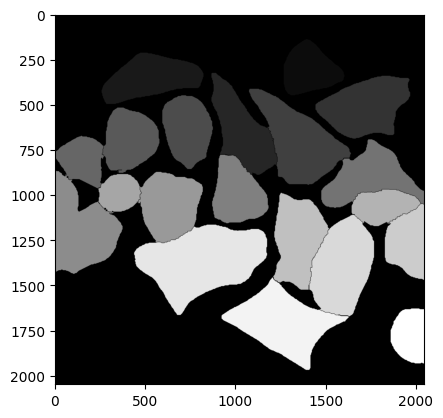

In [11]:
# Carregar o arquivo .npz
npz_file = np.load(path + mask_files[0])

# Listar as chaves (nomes) dos arrays contidos no arquivo
print(npz_file.files)

# Acessar uma máscara específica, por exemplo, se o arquivo contém uma chave chamada 'mask1'
mask = npz_file['arr_0']

# Verificar as dimensões da máscara
print(mask.shape)

plt.imshow(mask, cmap='gray')
plt.show()

In [12]:
# Carregar a máscara de uma imagem (exemplo de uma máscara em escala de cinza)
mascara = mask

intensidades_unicas = np.unique(mascara)

# Exibir as intensidades de cinza únicas
print("Intensidades de cinza únicas presentes na máscara:", intensidades_unicas)


Intensidades de cinza únicas presentes na máscara: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


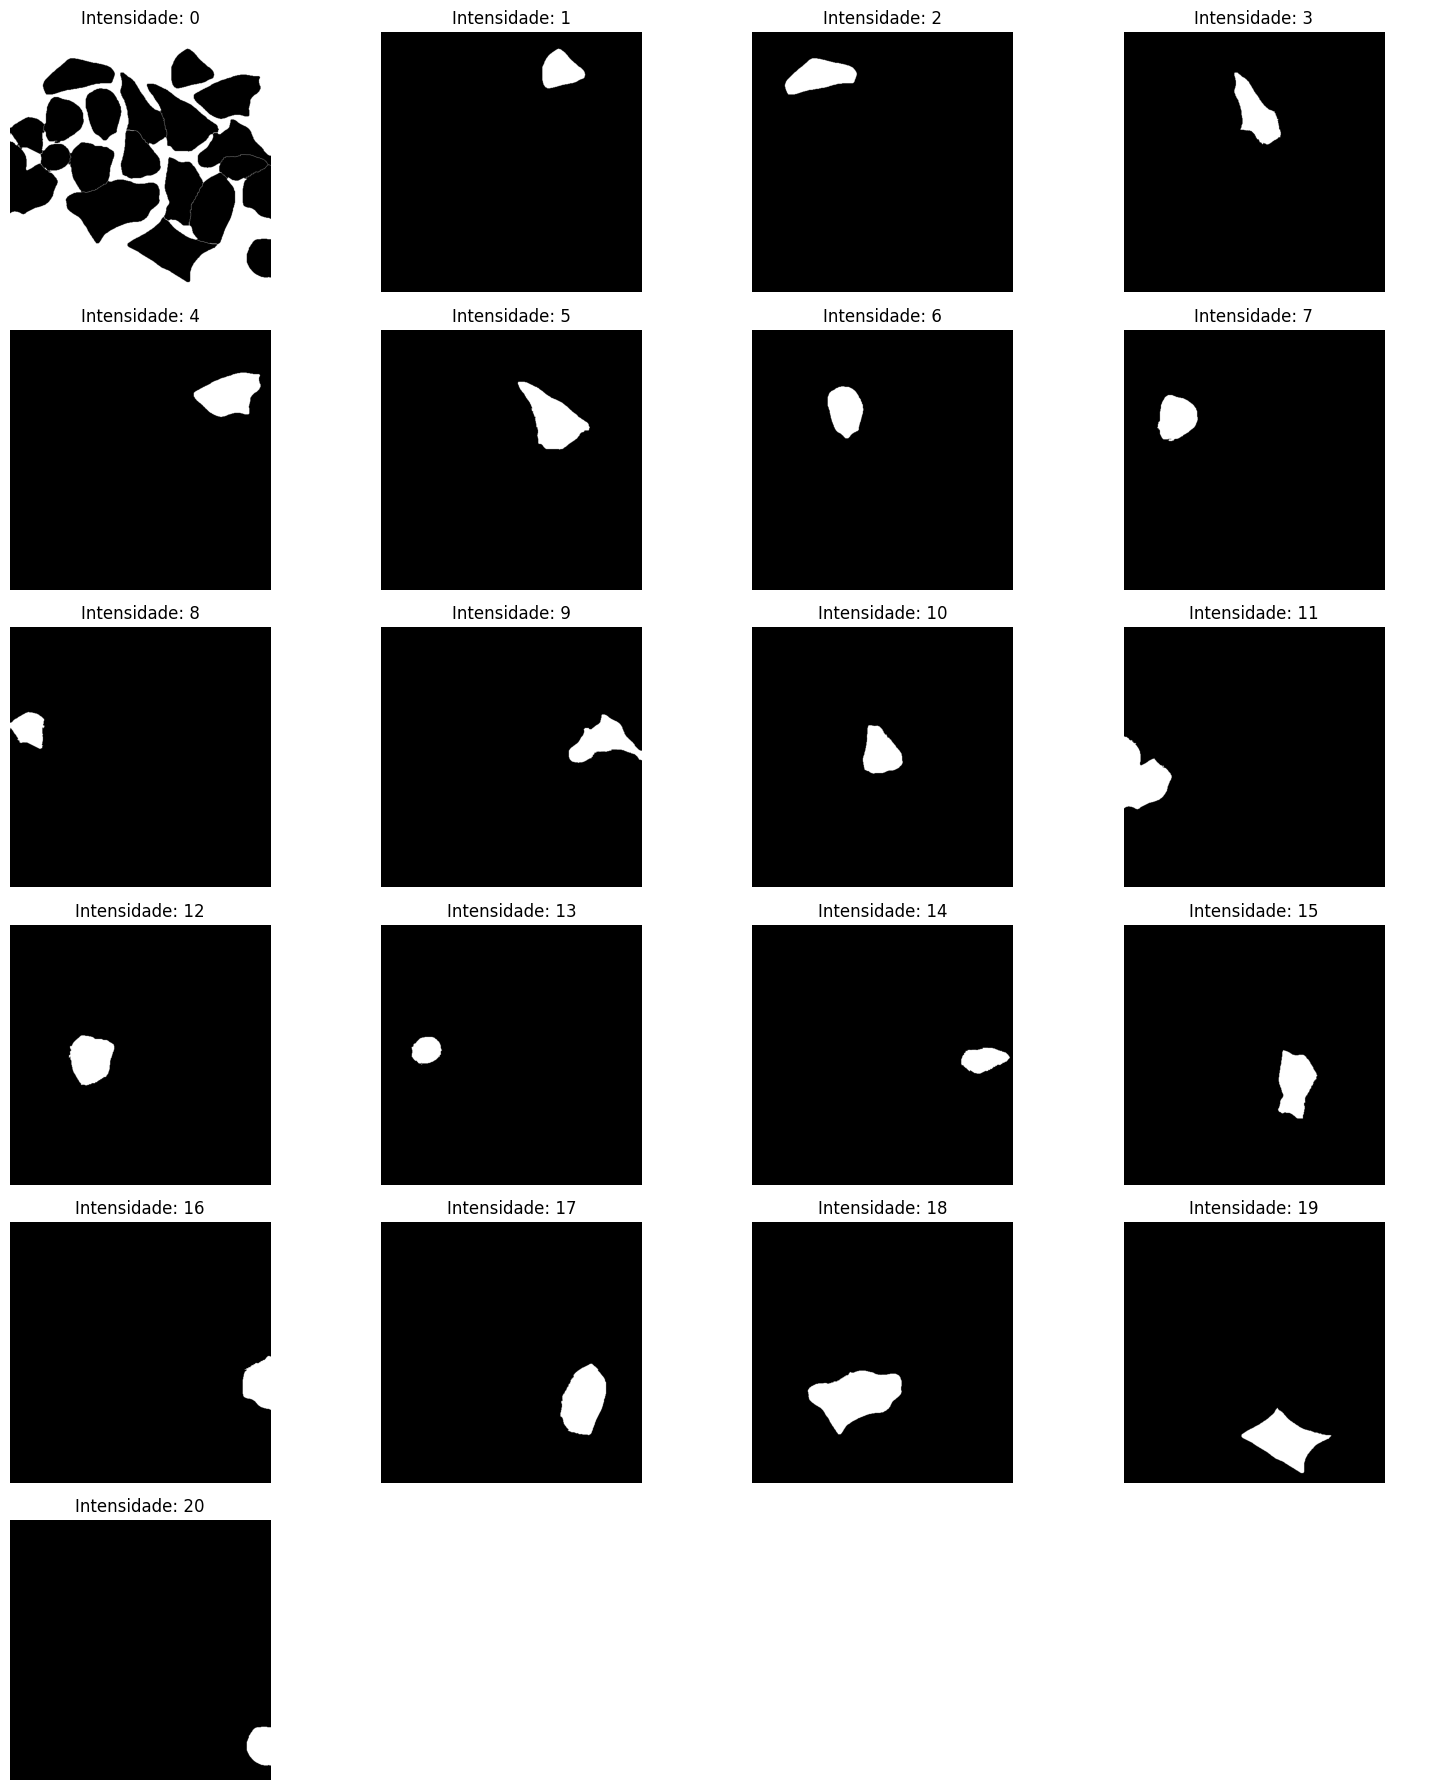

In [13]:
# Carregar a máscara de uma imagem (exemplo de uma máscara em escala de cinza)
mascara = mask

# Obter todas as intensidades de cinza únicas presentes na máscara
intensidades_unicas = np.unique(mascara)

# Número de intensidades únicas
num_intensidades = len(intensidades_unicas)

# Definir o tamanho da grade (número de linhas e colunas)
n_cols = 4  # Número de colunas no grid
n_rows = math.ceil(num_intensidades / n_cols)  # Calcula o número de linhas necessárias

# Criar a figura e os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))

# Garantir que axes seja um array plano para facilitar a iteração
axes = axes.flatten()

# Iterar sobre cada intensidade e criar uma máscara binária para ela
for i, intensidade in enumerate(intensidades_unicas):
    # Criar máscara binária para a intensidade atual
    mascara_binaria = (mascara == intensidade)

    # Exibir a máscara no grid
    axes[i].imshow(mascara_binaria, cmap='gray')
    axes[i].set_title(f'Intensidade: {intensidade}')
    axes[i].axis('off')  # Remover eixos para uma visualização mais limpa

# Remover subplots extras (se houver) em caso de número de intensidades menor que n_rows * n_cols
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Ajustar o layout para evitar sobreposição de títulos
plt.tight_layout()
plt.show()

### Get Test Images

In [6]:
# Test path
path = "/mnt/ssd/hpa-single-cell-image-classification/join_resized_test"

# List files
test_files = os.listdir(path)

# Get Images
dataset_dir = '/mnt/ssd/hpa-single-cell-image-classification/join_resized_test'
test = HPATestImages(images_dir=dataset_dir, transform=valid_transformations())

### Get Classification Model

In [3]:
# Instanciar o modelo
model = SqueezeNetCAM(num_classes=19)

# SqueezeNet
# Congelar todas as camadas por padrão
for param in model.parameters():
    param.requires_grad = False

# Descongelar a primeira camada (features[0]) e a última camada (classifier)
for param in model.squeezenet.features[0].parameters():
    param.requires_grad = True

# Descongelar a última camada
for param in model.squeezenet.classifier.parameters():
    param.requires_grad = True

# Definir o otimizador 
learning_rate = 0.0005
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate
)

# Carregar checkpoint
model_check_filename = '/mnt/ssd/hpa-single-cell-image-classification/checkpoint_15.pth'
epoch, train_losses, valid_losses = load_checkpoint(model, optimizer, filename=model_check_filename)

/home/juliana/Documentos/hpa-single-cell-classification/utils.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


### Classify Cells of a Image

In [7]:
# Supondo que test seja seu dataset e você queira a primeira imagem
image_test = test.__getitem__(0)

# A imagem provavelmente está em formato tensor, então, você pode precisar convertê-la para NumPy array
# Se a imagem estiver em formato tensor, converta para NumPy:
if isinstance(image_test, torch.Tensor):
    image_test = image_test.numpy()

# Vamos assumir que sua imagem tenha 4 canais (RGBY)
# E que você tenha carregado o Cell Segmentator como mostrado anteriormente:
NUCLEAR_MODEL = 'nuclear-model.pth'
CELL_MODEL = 'cell-model.pth'

segmentator = CellSegmentator(
    NUCLEAR_MODEL, 
    CELL_MODEL, 
    padding=True,  # Para ajustar as bordas da imagem
    multi_channel_model=True  # Modelo com suporte a múltiplos canais
)

# Agora, vamos separar os canais da imagem (supondo que eles estejam em uma lista ou tensor com 4 canais)
# Certifique-se de que a imagem tem os canais corretos
nuclear_img = image_test[0]  # Canal azul (núcleo)
membrane_img = image_test[1]  # Canal vermelho (membrana)
organelle_img = image_test[2]  # Canal verde (proteínas/organelas)
protein_img = image_test[3]  # Canal amarelo (proteínas)

# Vamos organizar os canais conforme o Segmentator requer
images = [[nuclear_img], [membrane_img, organelle_img, protein_img]]

# Agora, vamos segmentar os núcleos
nuclear_masks = segmentator.pred_nuclei(images[0])

# E segmentar as células (membranas/citoplasma)
cell_masks = segmentator.pred_cells(images[1])

# As máscaras geradas estão agora em 'nuclear_masks' e 'cell_masks'
# Para visualizá-las ou salvar, você pode fazer algo como:

# Exibir a máscara de núcleos
plt.imshow(nuclear_masks[0], cmap='gray')
plt.title('Máscara de Núcleos')
plt.show()

# Exibir a máscara de células
plt.imshow(cell_masks[0], cmap='gray')
plt.title('Máscara de Células')
plt.show()


Image([[[-0.6545, -0.6545, -0.2092,  ...,  6.7243,  6.7243,  6.7879],
        [-0.5273, -0.0184, -0.2092,  ...,  7.0105,  7.4558,  7.4558],
        [ 0.0452, -0.1138, -0.0502,  ...,  6.9469,  7.4558,  7.3604],
        ...,
        [ 7.4558,  7.4558,  7.4558,  ..., -0.4001, -0.3683, -0.6545],
        [ 7.4558,  7.4558,  7.4558,  ..., -0.6227, -0.2728, -0.6545],
        [ 7.4558,  7.4558,  7.4558,  ..., -0.6545,  0.1406, -0.6545]],

       [[-0.6316, -0.5392, -0.5700,  ...,  7.2239,  7.2239,  7.0699],
        [-0.6316, -0.5700, -0.6008,  ...,  7.2239,  7.2239,  7.2239],
        [-0.6316, -0.6316, -0.6316,  ...,  7.2239,  7.2239,  7.2239],
        ...,
        [ 7.2239,  7.2239,  7.2239,  ..., -0.6316, -0.6316, -0.6316],
        [ 7.2239,  7.2239,  7.2239,  ..., -0.6316, -0.6316, -0.6316],
        [ 7.2239,  7.2239,  7.2239,  ..., -0.6316, -0.6316, -0.6316]],

       [[-0.1577,  0.2284,  0.3938,  ..., -0.0474, -0.1301, -0.1853],
        [-0.3232, -0.0750, -0.3232,  ...,  0.1181,  0.5042, 

### Classify for all Images

### Save on the Needed Format